In [39]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np

sitk_t1=sitk.ReadImage('../files/t1.nii.gz')
t1=sitk.GetArrayFromImage(sitk_t1)
print(t1.shape)

(90, 256, 256)


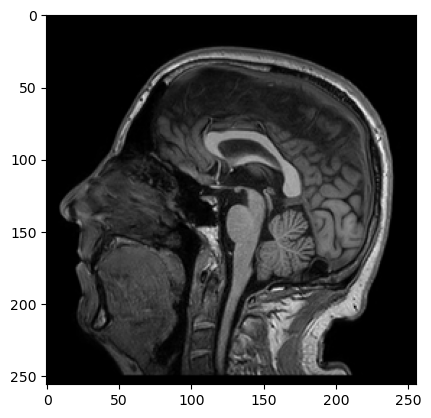

In [2]:
import matplotlib.pyplot as plt
plt.imshow(t1[45],cmap='gray')

(9, 20, 2)


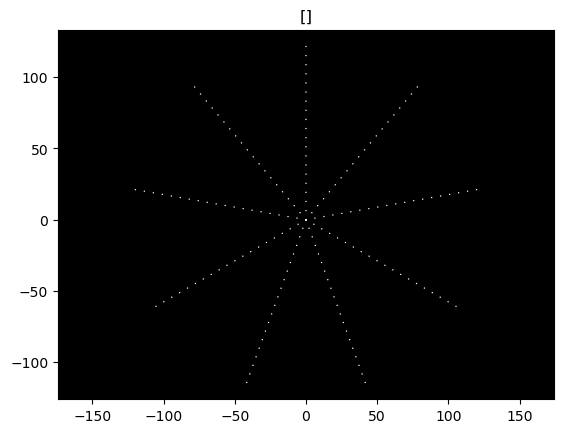

In [41]:
import sigpy.mri
import sigpy.plot
coord = sigpy.mri.radial([9,20,2],[256,256],golden=False)
print(coord.shape)
# coord
sigpy.plot.ScatterPlot(coord)

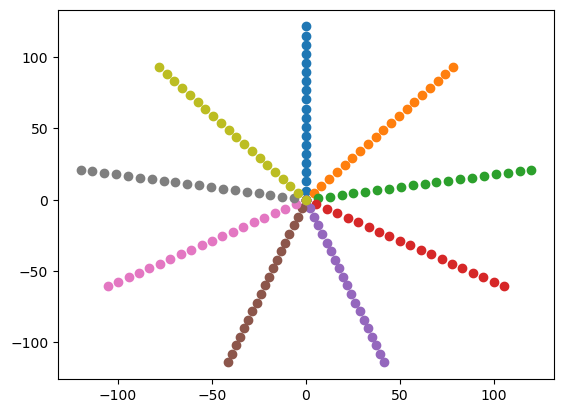

[[  0.    0. ]
 [  0.    6.4]
 [  0.   12.8]
 [  0.   19.2]
 [  0.   25.6]
 [  0.   32. ]
 [  0.   38.4]
 [  0.   44.8]
 [  0.   51.2]
 [  0.   57.6]
 [  0.   64. ]
 [  0.   70.4]
 [  0.   76.8]
 [  0.   83.2]
 [  0.   89.6]
 [  0.   96. ]
 [  0.  102.4]
 [  0.  108.8]
 [  0.  115.2]
 [  0.  121.6]]


In [42]:
for spoke in coord:
    plt.scatter(spoke[:,0],spoke[:,1])
plt.show()
print(coord[0])

# Test to discretize a Cartesian plane


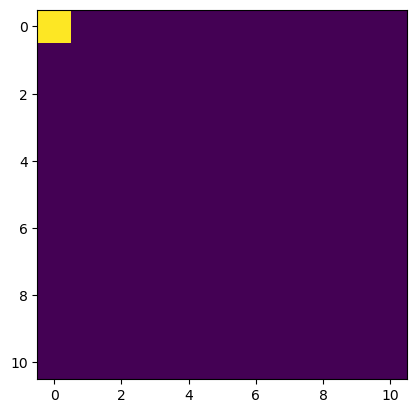

In [43]:
grid = np.zeros([11,11])
grid[0,0] = 1
plt.imshow(grid)

In [44]:
grid_extent = np.array([[-1,1],[-1,1]])
grid_length = np.array([abs(grid_extent[0,1]-grid_extent[0,0]),abs(grid_extent[1,1]-grid_extent[1,0])])
pixel_size = grid_length/grid.shape
print(f'Pixel size: {pixel_size}')
grid_offset = np.array([abs(grid_extent[0,0]),abs(grid_extent[1,0])]) + 0.5*pixel_size
print(f'Grid offset: {grid_offset}')
print(f'grid_offset/px_size = {grid_offset/pixel_size}')

Pixel size: [0.18181818 0.18181818]
Grid offset: [1.09090909 1.09090909]
grid_offset/px_size = [6. 6.]


10 10


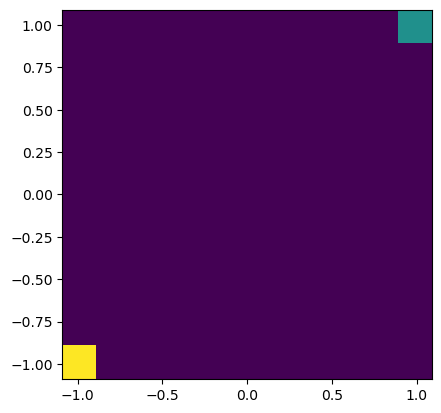

In [45]:
p = np.array([0.75,0.75])
idx = (np.floor((p + grid_offset)/pixel_size)).astype(int)
print(*idx)
grid[idx[0],idx[1]] = 0.5
plt.imshow(np.flipud(grid.T),extent=(-1-pixel_size[0]/2,1+pixel_size[0]/2,-1-pixel_size[1]/2,1+pixel_size[1]/2))

**Need:** A way of locating coordinates (x,y) of a continuous plane in a NxM grid, representing an image. (x,y) has to map to a given pixel in the image `I`, identified by two indices. 

The operation `np.round(point - grid_offset/pixel_size).astype(int)` gives the two indices of the image pixel corresponding to the point (x,y). The offset is always taken to be 0.5 times the size of the pixel, so that the origin lies at the center of the pixel `I[0,0]`.

Since we assume the origin to be at the bottom left corner of the image, but the image has to be transposed and flipped upside-down 

In [46]:
sigpy.gridding(grid,[2.25,6.1]

SyntaxError: incomplete input (1094691544.py, line 1)

# Back to the task

SimpleItk offers a way of accessing a given pixel in an image with `image.GetPixel((0,0))`, and a way of knowing the physical location of that pixel with `image.TransformIndexToPhysicalPoint((0,0))`. Nevertheless, SimpleITK locates the images in physical space, so it might be difficult to work with the direct representation of the image.

In [6]:
sitk_t1.GetPixel((45,0,0))

0

In [7]:
sitk_t1.TransformIndexToPhysicalPoint((45,0,0))

(94.5030177085908, -90.80690074756689, 85.40484052909349)

It is probably better to use `skimage.map_coordinates`: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html#scipy.ndimage.map_coordinates

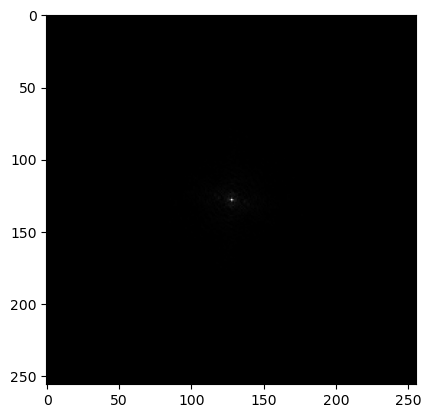

In [50]:
t1_fft = sigpy.fft(t1[45])
plt.imshow(np.abs(t1_fft), cmap='gray')

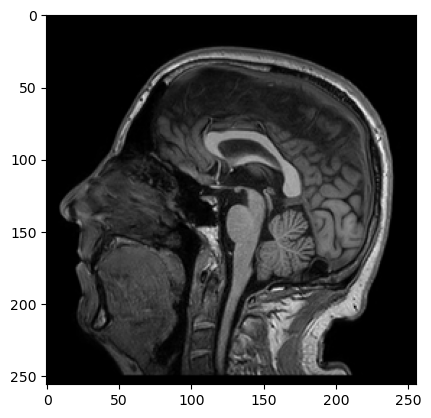

In [51]:
t1_ifft = sigpy.ifft(t1_fft)
plt.imshow(np.abs(t1_ifft), cmap='gray')

Transform the spokes so that the origin coincides with the origin of the image. Note that the y-values appear to be flipped, but in image space they are right, since the image's coordinate system is left-handed with the origin at the top left corner.

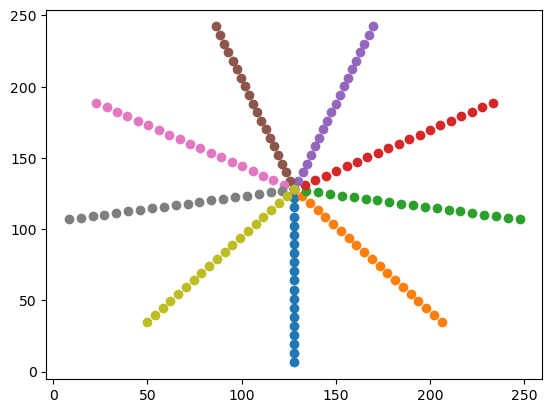

In [63]:
coord_trf = []
for spoke in coord:
    new_spoke=[]
    for point in spoke:
        new_point = [point[0]+128, abs(point[1]-128)]
        new_spoke.append(new_point)
    coord_trf.append(new_spoke)
coord_trf = np.array(coord_trf)
for spoke in coord_trf:
    plt.scatter(spoke[:,0],spoke[:,1])
plt.show()

It works, so let's create a function to automate this for the spokes we get

In [52]:
def translate_spokes_to_img_coord(spokes, im_size=(256,256)):
    x_shift = np.floor(im_size[1]/2) # x_shift determines how columns will be shifted
    y_shift = np.floor(im_size[0]/2) # y_shift determines how rows will be shifted
    new_spokes = []
    for spoke in spokes:
        new_spoke = []
        for point in spoke:
            new_point = [point[0] + x_shift, abs(point[1] - y_shift)]
            new_spoke.append(new_point)
        new_spokes.append(new_spoke)
    return np.array(new_spokes)

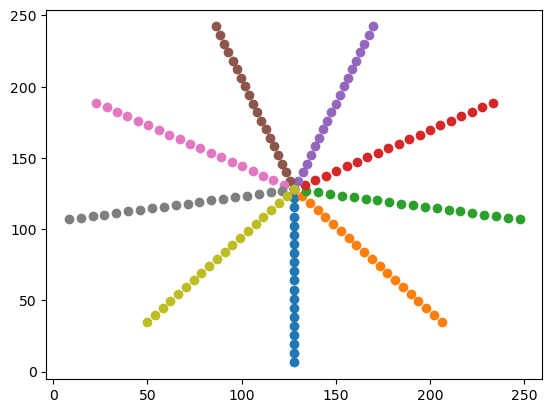

In [67]:
new_spokes = translate_spokes_to_img_coord(coord)
for spoke in new_spokes:
    plt.scatter(spoke[:,0],spoke[:,1])
plt.show()

Testing map coordinates:

In [47]:
a = np.arange(10*10).reshape((10,10))
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [48]:
from scipy import ndimage
a[4,6]=0
a[5,6]=0
print(a)
ndimage.map_coordinates(a,[[4.5,0.8],[6.9,1.9]], order=1, mode='nearest')

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45  0 47 48 49]
 [50 51 52 53 54 55  0 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


array([47, 10])

In [49]:
sigpy.interpolate(a, coord=np.array([[[4.5,6.9],[0.8, 1.9]],[[2.1,1.2],[2.3,8.9]]]))

array([[46,  8],
       [20, 30]])

Turns out, `sigpy.interpolate` does the same as `ndimage.map_coordinates`, but with spline interpolation, and with a more logical way of expressing the points.
https://sigpy.readthedocs.io/en/latest/generated/sigpy.interpolate.html#sigpy.interpolate

In [134]:
sigpy.gridding(np.array([[100,100],[100,100]]), np.array([[[5.2,6.8],[8.2,3.1]],[[1,2],[3.3,4.4]]]), np.array([10,10]))

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  41,  28,   0,   0,   0,   0],
       [  0,   0,   0,   0,  17,  12,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  16,  63,   0,   0],
       [  0,   0,   0,   0,   0,   0,   4,  16,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  72,   8,   0,   0,   0,   0,   0],
       [  0,   0,   0,  17,   1,   0,   0,   0,   0,   0]])

`sigpy.gridding` can be used to insert the values in the image.
https://sigpy.readthedocs.io/en/latest/generated/sigpy.gridding.html#sigpy.gridding

Let's try the process on a toy-image, and paint a 1 in every coordinate marked by the spokes:

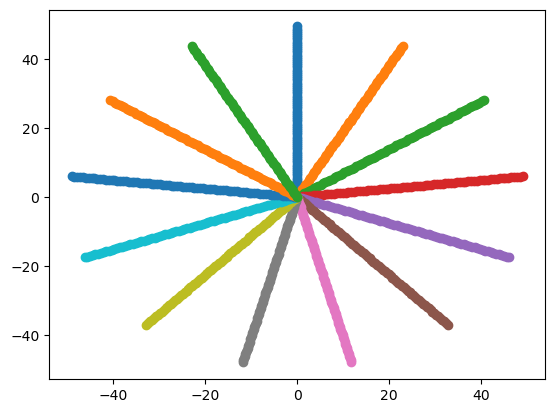

In [159]:
toy_spokes = sigpy.mri.radial([13,80,2],[100,100],golden=False)
for spoke in toy_spokes:
    plt.scatter(spoke[:,0],spoke[:,1])
plt.show()

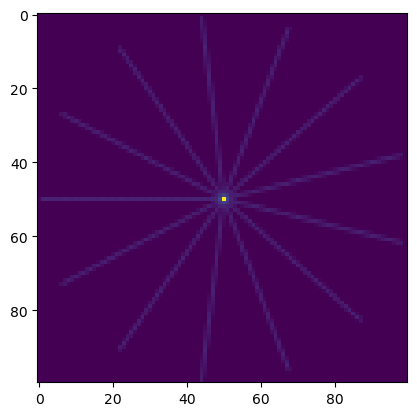

In [162]:
toy_values = 100*np.ones((toy_spokes.shape[0],toy_spokes.shape[1],1))
toy_spokes_translated = translate_spokes_to_img_coord(toy_spokes, (100,100))
toy_image = sigpy.gridding(toy_values, toy_spokes_translated, np.array([100,100]))
plt.imshow(toy_image)

Now test it on the image

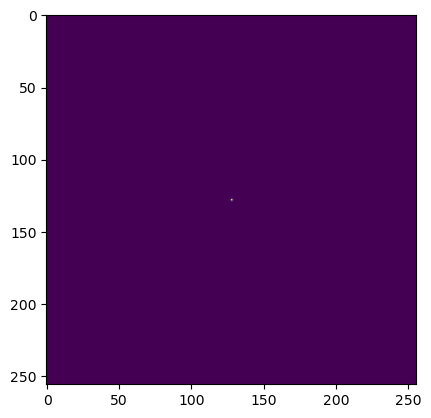

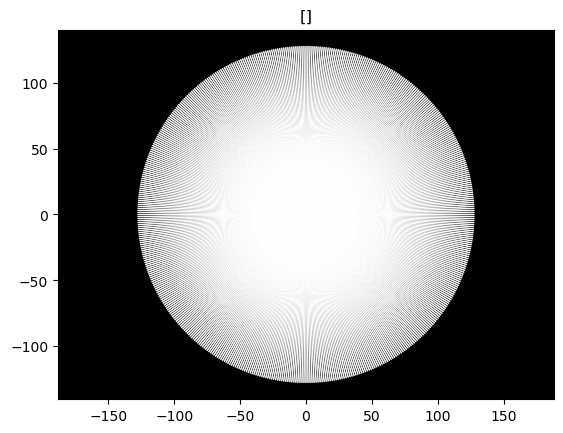

In [55]:
spokes_ok = sigpy.mri.radial([520,256,2],[256,256],golden=False)
spokes_ok_tr = translate_spokes_to_img_coord(spokes_ok, (256,256))
sampled_kspace = sigpy.interpolate(t1_fft, spokes_ok_tr)
sampled_fft = sigpy.gridding(sampled_kspace,spokes_ok_tr,np.array([256,256]))
plt.imshow(np.abs(sampled_fft))
sampled_fft.shape
sigpy.plot.ScatterPlot(spokes_ok)

In [56]:
# Compensation factor
dcf = (spokes_ok)

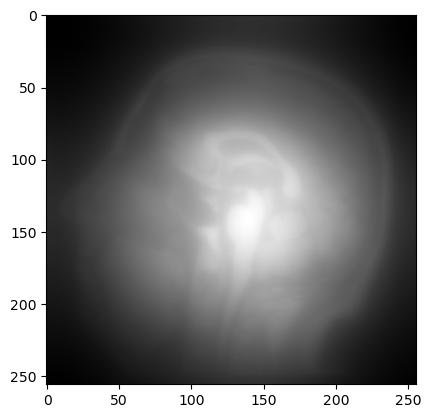

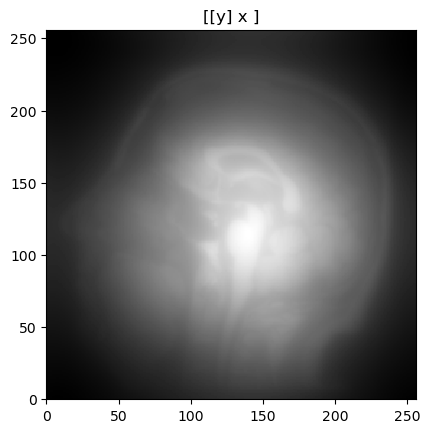

In [57]:
reco_t1 = sigpy.ifft(sampled_fft)
plt.imshow(np.abs(reco_t1),cmap='gray')
sigpy.plot.ImagePlot(sigpy.flip(reco_t1,axes=(2,)),mode='m')

In [29]:
help(sitk.GetArrayFromImage)

Help on function GetArrayFromImage in module SimpleITK.extra:

GetArrayFromImage(image: SimpleITK.SimpleITK.Image) -> 'numpy.ndarray'
    Get a NumPy ndarray from a SimpleITK Image.
    
    This is a deep copy of the image buffer and is completely safe and without potential side effects.



## From tutorial:

In [20]:
import numpy as np
import sigpy as sp
import sigpy.plot as pl
import matplotlib.pyplot as plt
import sigpy.mri as mri


In [3]:
ksp = np.load('../files/projection_ksp.npy')
coord_file = np.load('../files/projection_coord.npy')
print('k-space array shape: {}'.format(ksp.shape))
print('coordinate array shape: {}'.format(coord_file.shape))

k-space array shape: (12, 96, 512)
coordinate array shape: (96, 512, 2)


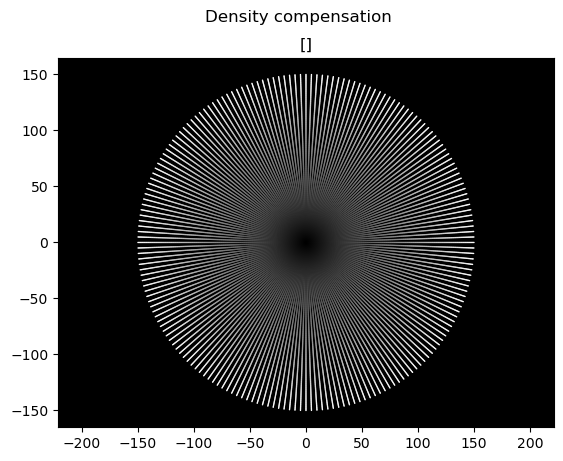

In [9]:
# Density compensation factor
dcf = (coord_file[..., 0]**2 + coord_file[..., 1]**2)**0.5
pl.ScatterPlot(coord_file, dcf, title='Density compensation')

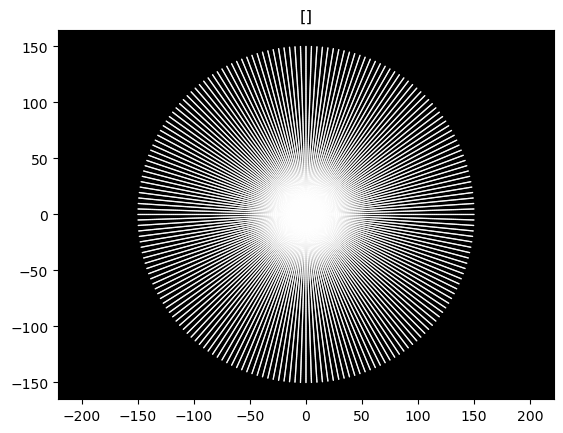

array([[ 1.5000000e+02, -1.8369703e-14],
       [ 1.4941292e+02, -1.8297806e-14],
       [ 1.4882582e+02, -1.8225908e-14],
       ...,
       [-1.4882582e+02,  1.8225908e-14],
       [-1.4941292e+02,  1.8297806e-14],
       [-1.5000000e+02,  1.8369703e-14]], dtype=float32)

In [32]:
pl.ScatterPlot(coord_file)
coord_file[0]

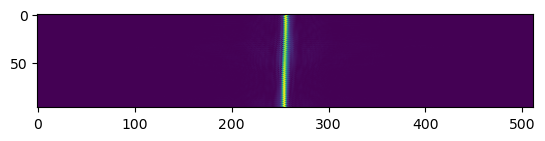

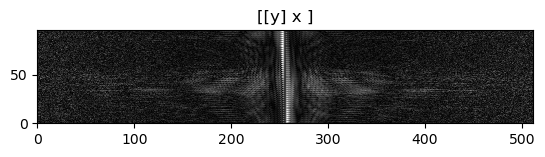

In [16]:
plt.imshow(np.abs(ksp[1]))
pl.ImagePlot(ksp[1]*dcf)

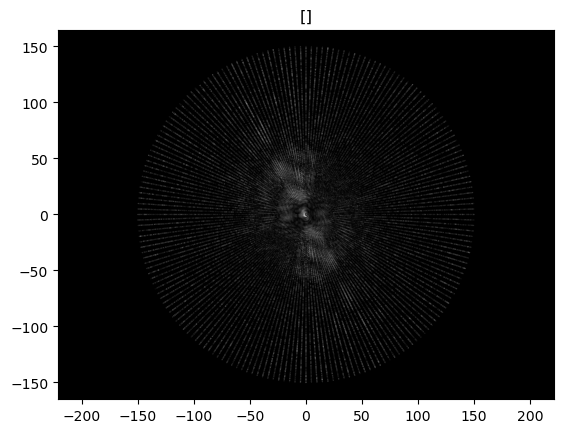

In [10]:
pl.ScatterPlot(coord_file, dcf*ksp[1])

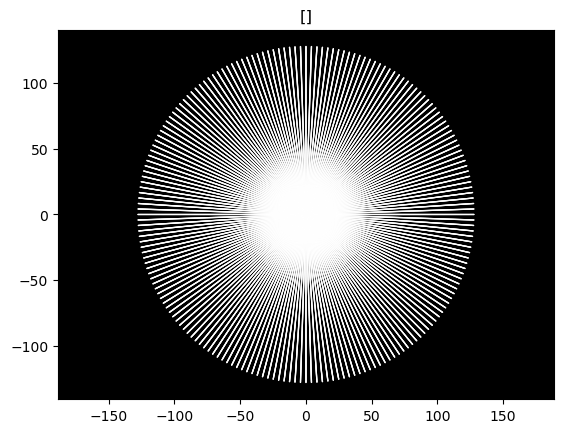

(192, 512, 2)

In [38]:
test_coords = mri.radial([192,512,2],[256,256],golden=False)
pl.ScatterPlot(test_coords)
test_coords.shape

In [37]:
test_coords[30]

array([[ 0.00000000e+00, -0.00000000e+00],
       [ 2.30969883e-01, -9.56708581e-02],
       [ 4.61939766e-01, -1.91341716e-01],
       ...,
       [ 1.17563671e+02, -4.86964668e+01],
       [ 1.17794640e+02, -4.87921376e+01],
       [ 1.18025610e+02, -4.88878085e+01]])